<a href="https://colab.research.google.com/github/samarth-kashyap/NotebookTemplates/blob/main/conv_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)
train_transform = transforms.Compose([transforms.ToTensor(), ])
test_transform = transforms.Compose([transforms.ToTensor(), ])
train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [2]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x



class Decoder(nn.Module):    
    def __init__(self, encoded_space_dim, fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [3]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cuda


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [4]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        #print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   


 EPOCH 1/30 	 train loss 0.12293318659067154 	 val loss 0.06576040387153625


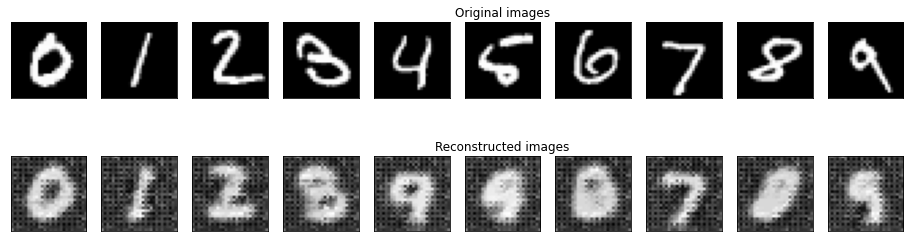


 EPOCH 2/30 	 train loss 0.054524440318346024 	 val loss 0.04765865579247475


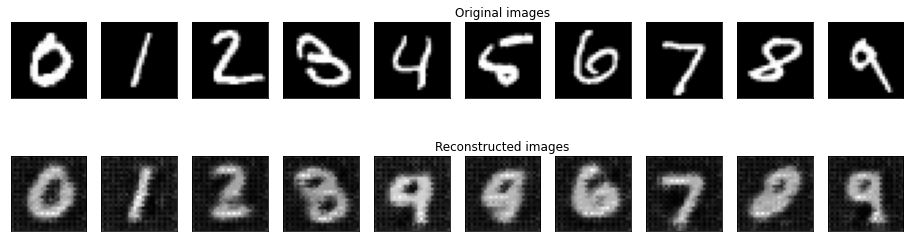


 EPOCH 3/30 	 train loss 0.04288216680288315 	 val loss 0.038966964930295944


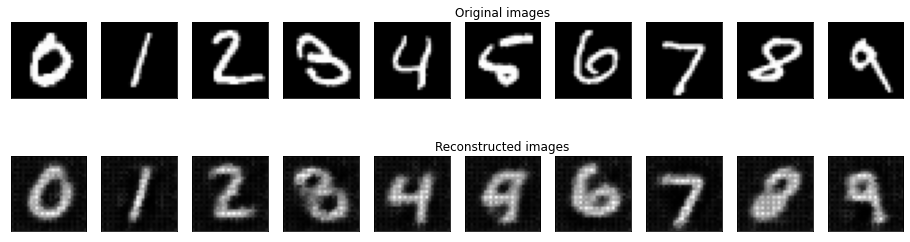


 EPOCH 4/30 	 train loss 0.03591376543045044 	 val loss 0.03407999500632286


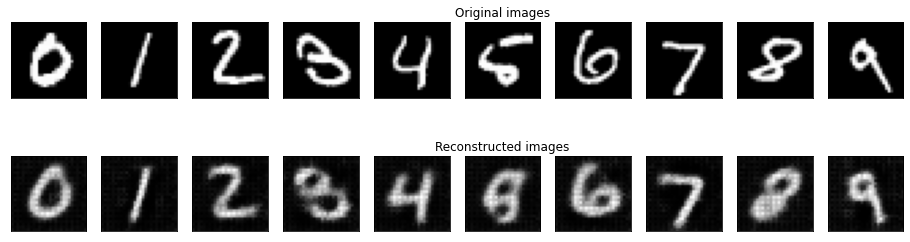


 EPOCH 5/30 	 train loss 0.03283010050654411 	 val loss 0.03181713446974754


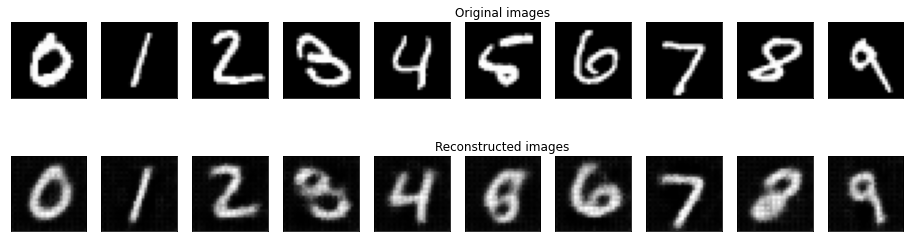


 EPOCH 6/30 	 train loss 0.03127097710967064 	 val loss 0.030744420364499092


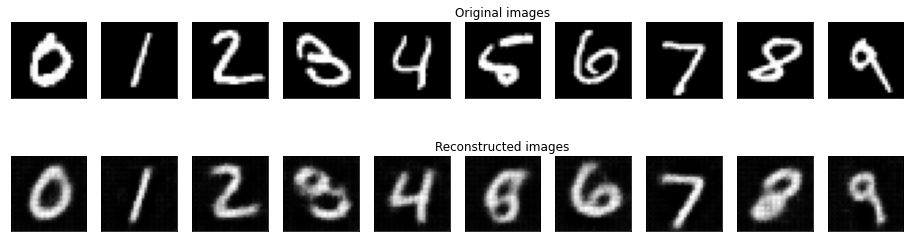


 EPOCH 7/30 	 train loss 0.03029767982661724 	 val loss 0.02994552068412304


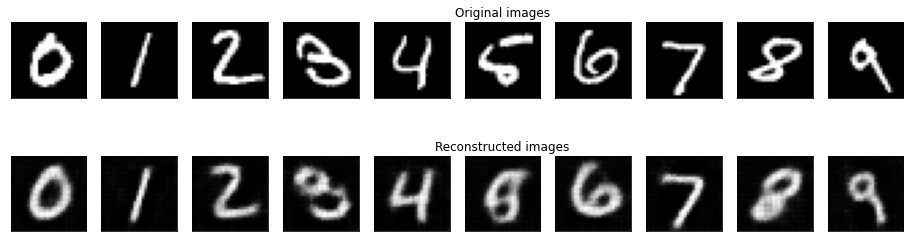


 EPOCH 8/30 	 train loss 0.029614737257361412 	 val loss 0.029435794800519943


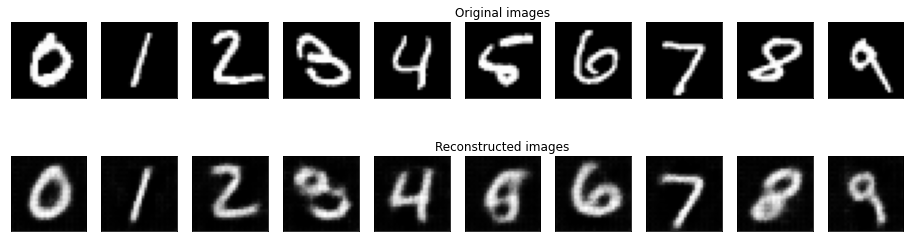


 EPOCH 9/30 	 train loss 0.029101260006427765 	 val loss 0.02909834496676922


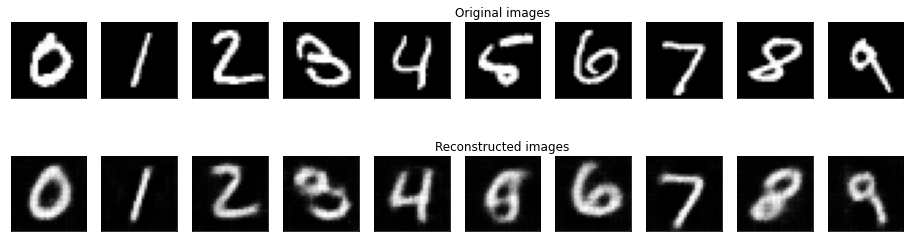


 EPOCH 10/30 	 train loss 0.028694158419966698 	 val loss 0.028737463057041168


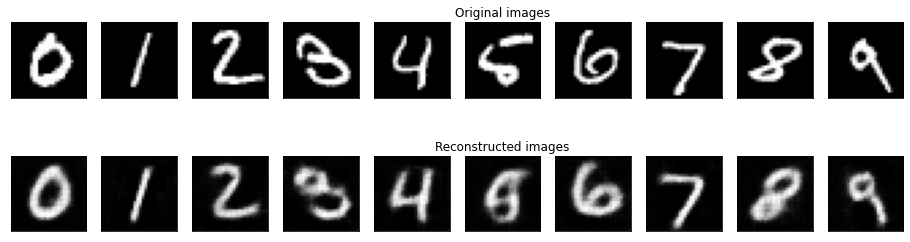


 EPOCH 11/30 	 train loss 0.0283522866666317 	 val loss 0.028437649831175804


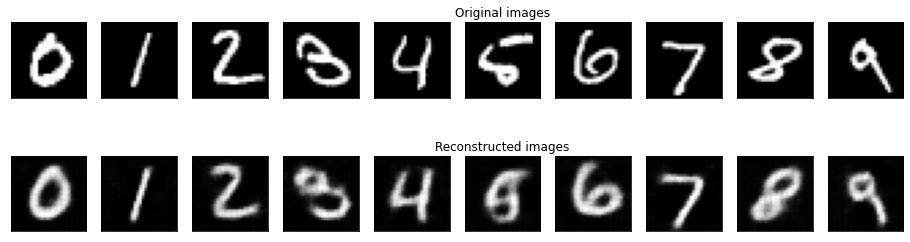


 EPOCH 12/30 	 train loss 0.02807222492992878 	 val loss 0.028065141290426254


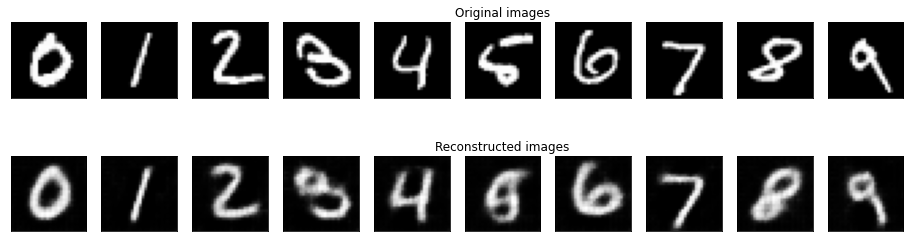


 EPOCH 13/30 	 train loss 0.02779751643538475 	 val loss 0.02780313976109028


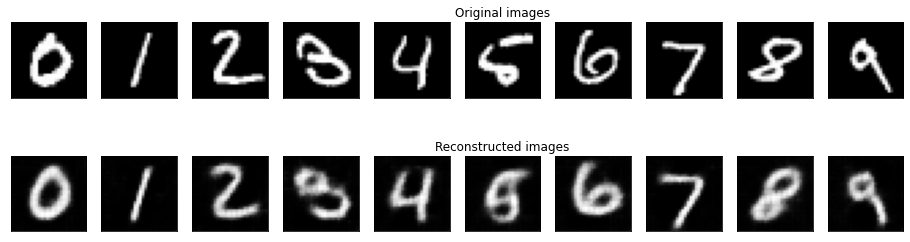


 EPOCH 14/30 	 train loss 0.027563728392124176 	 val loss 0.027635958045721054


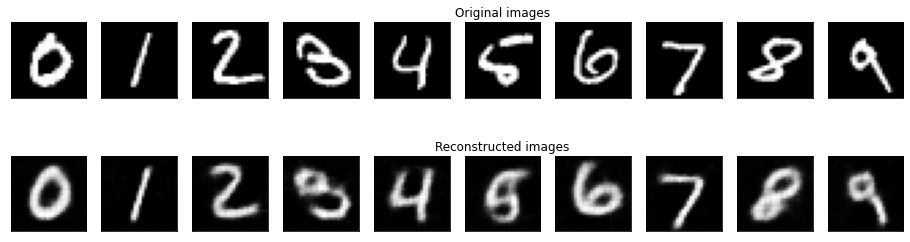


 EPOCH 15/30 	 train loss 0.02736031450331211 	 val loss 0.027485733851790428


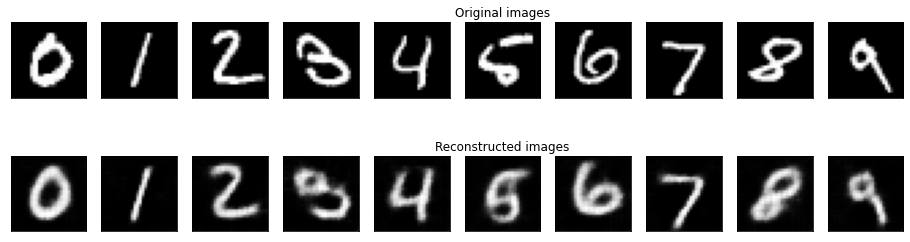


 EPOCH 16/30 	 train loss 0.027174394577741623 	 val loss 0.027327286079525948


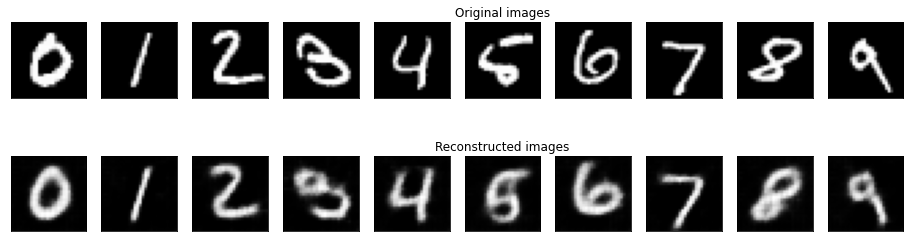


 EPOCH 17/30 	 train loss 0.027005983516573906 	 val loss 0.02718641236424446


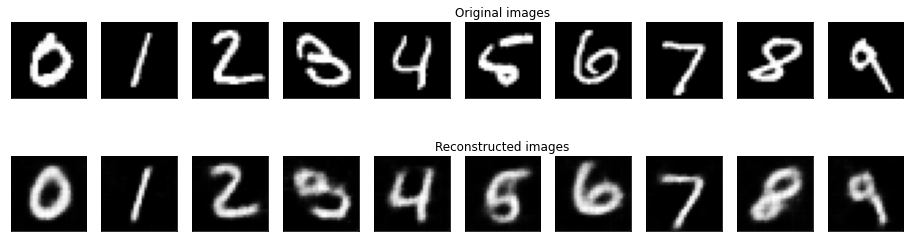


 EPOCH 18/30 	 train loss 0.02684823051095009 	 val loss 0.027064865455031395


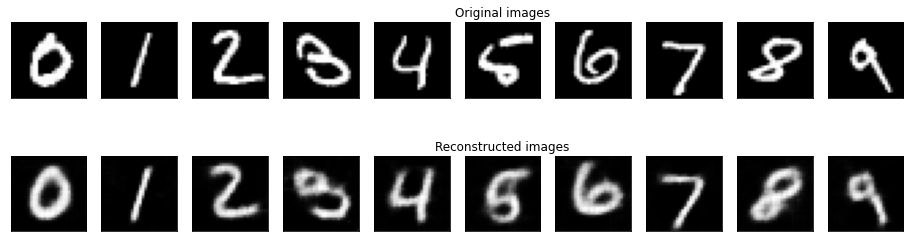


 EPOCH 19/30 	 train loss 0.026705771684646606 	 val loss 0.026982465758919716


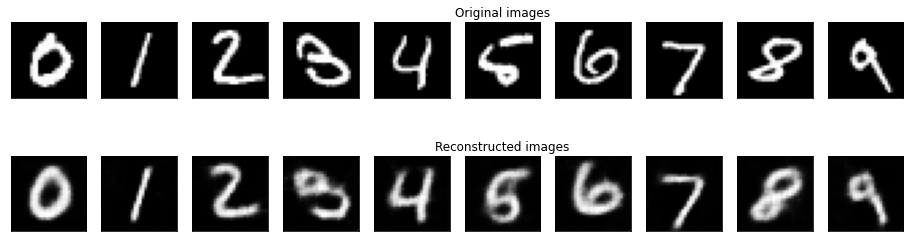


 EPOCH 20/30 	 train loss 0.02656763419508934 	 val loss 0.026923971250653267


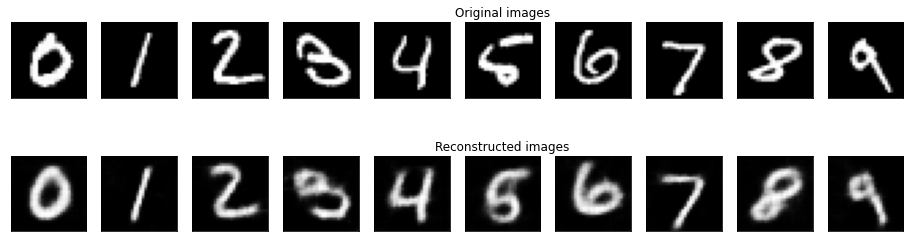


 EPOCH 21/30 	 train loss 0.026464330032467842 	 val loss 0.02688509225845337


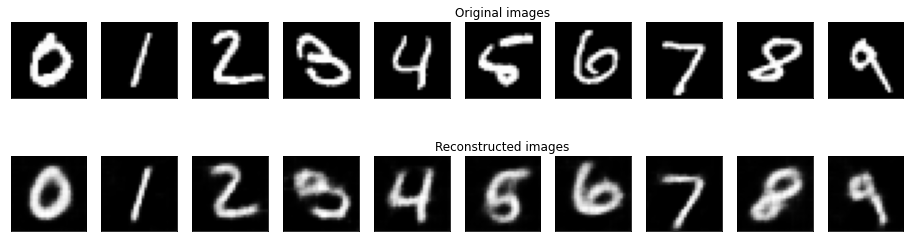


 EPOCH 22/30 	 train loss 0.026362033560872078 	 val loss 0.026837104931473732


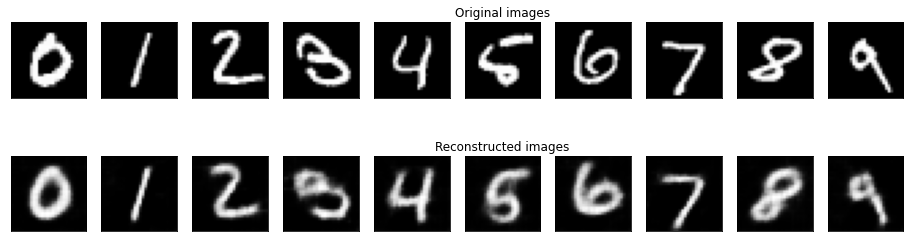


 EPOCH 23/30 	 train loss 0.026265138760209084 	 val loss 0.02676220051944256


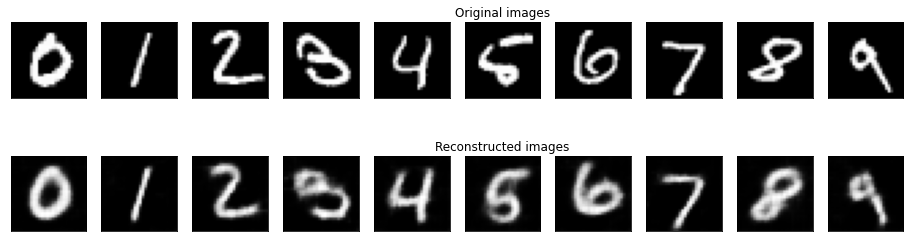


 EPOCH 24/30 	 train loss 0.026178810745477676 	 val loss 0.026694998145103455


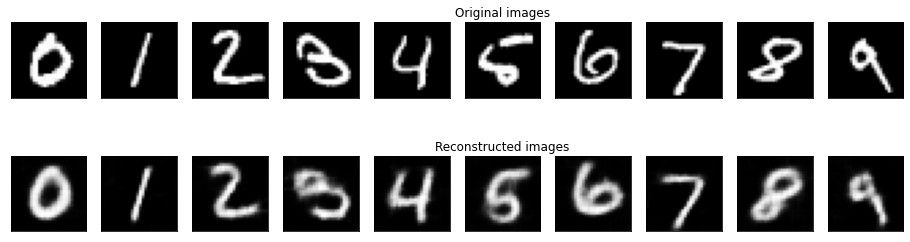


 EPOCH 25/30 	 train loss 0.026094667613506317 	 val loss 0.026678742840886116


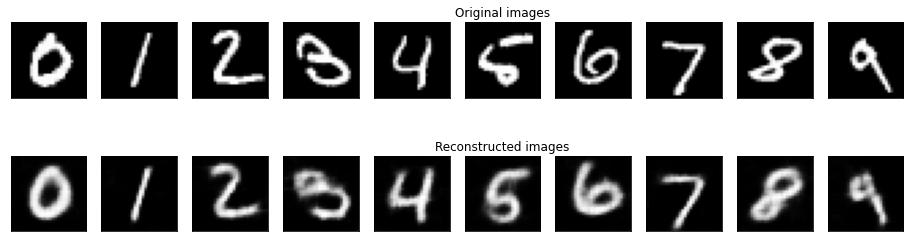


 EPOCH 26/30 	 train loss 0.02602544240653515 	 val loss 0.026535464450716972


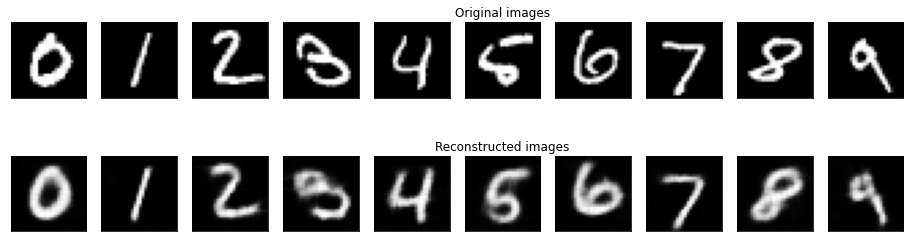


 EPOCH 27/30 	 train loss 0.025965766981244087 	 val loss 0.02660360373556614


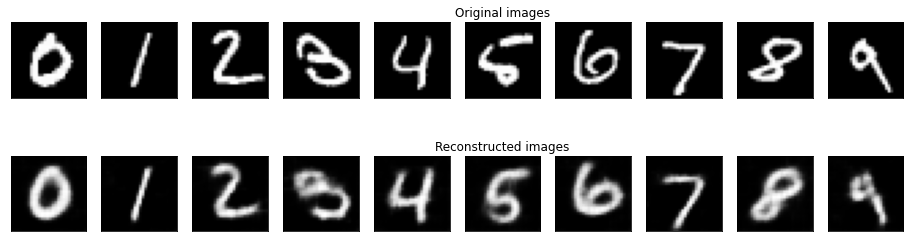


 EPOCH 28/30 	 train loss 0.025908807292580605 	 val loss 0.026614893227815628


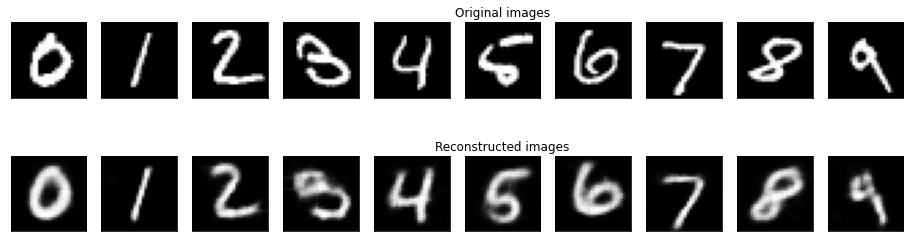


 EPOCH 29/30 	 train loss 0.02584717608988285 	 val loss 0.02650235965847969


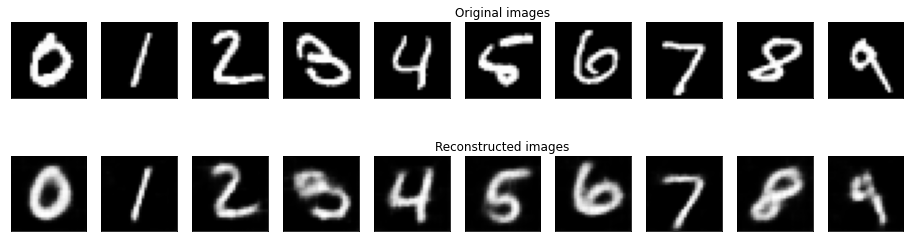


 EPOCH 30/30 	 train loss 0.02578575536608696 	 val loss 0.026453806087374687


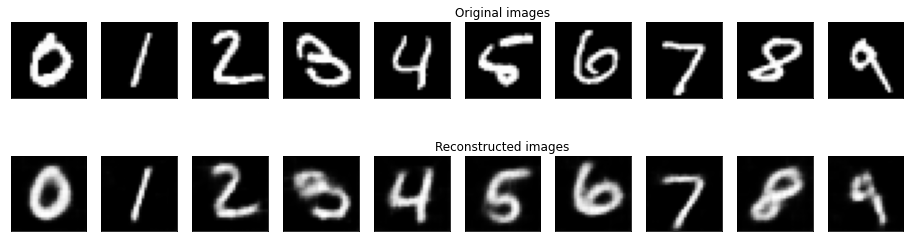

In [5]:
num_epochs = 30
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,
   train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)

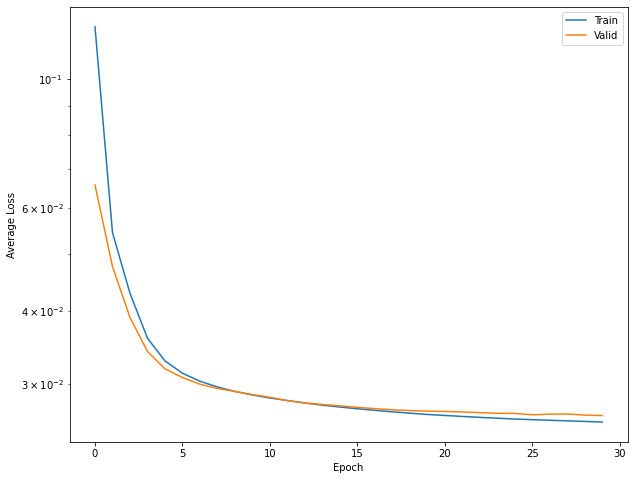

In [8]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

tensor([-0.1890,  0.0587,  0.0017, -0.0578])
tensor([0.6318, 0.6680, 0.7027, 0.6121])


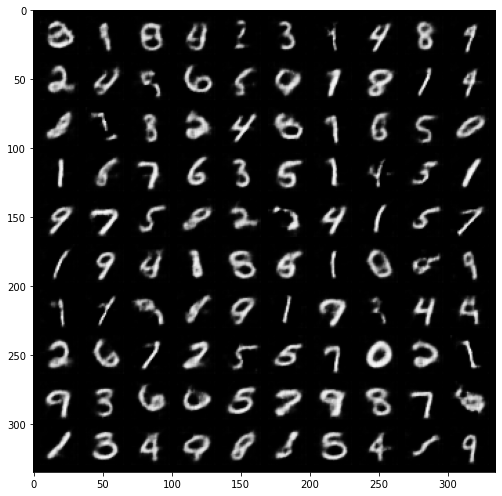

In [9]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs 
    test_iterator = iter(test_loader)
    images, labels = next(test_iterator)
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100], 10, 5))
    plt.show()

In [10]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████| 10000/10000 [00:09<00:00, 1021.77it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,label
0,-1.680886,1.224536,-0.587447,0.654415,7
1,0.788827,0.944427,1.271894,0.822586,2
2,0.385907,0.980669,-0.711770,0.809086,1
3,-0.464075,-0.898054,0.546063,-0.368234,0
4,-0.690403,-0.336538,-1.224843,-1.173146,4
...,...,...,...,...,...
9995,-0.113421,0.571640,0.903759,1.343619,2
9996,0.386070,0.148451,0.754803,-0.194730,3
9997,-0.609359,-0.057854,-1.237353,-0.242739,4
9998,0.873710,-1.187853,-0.968764,-0.041402,5


In [11]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

